<h3>Référence à la partie II)B)3): Mise en place d'une image quantique à partir d'une image classique 2x2px: (I0,I1,I2,I3)</h3>   

c0:
0.0
c1:
0.37219211070445407
c2:
0.5582881660566811
c3:
0.7414764705440295


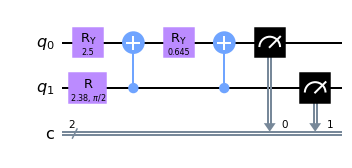

In [2]:
# Initialisation
# Imports nécessaire:
import numpy as np
from math import pi, sqrt
# Import Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit import(
  execute,
  BasicAer)
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
# Import des outils graphiques
from qiskit.visualization import plot_histogram, array_to_latex

#Implémentation de l'image 2x2px (I0,I1,I2,I3)
I0 = 0
I1 = 128
I2 = 192
I3 = 255

#Passage à l'image quantique
c0 = I0/sqrt(I0**2+I1**2+I2**2+I3**2)
c1 = I1/sqrt(I0**2+I1**2+I2**2+I3**2)
c2 = I2/sqrt(I0**2+I1**2+I2**2+I3**2)
c3 = I3/sqrt(I0**2+I1**2+I2**2+I3**2)

print("c0:")
print(c0)
print("c1:")
print(c1)
print("c2:")
print(c2)
print("c3:")
print(c3)

#Préparation de l'état de l'image quantique via la mise en place d'un circuit quantique: 
qc = QuantumCircuit(2, 2)
qc.ry(2.5,0)
qc.r(2.38,pi/2,1)
qc.cx(1,0)
qc.ry(0.645,0)
qc.cx(1,0)

# Mesure
qc.measure([0,1], [0,1])
simulator = QasmSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)
# Affichage du circuit:
qc.draw('mpl')

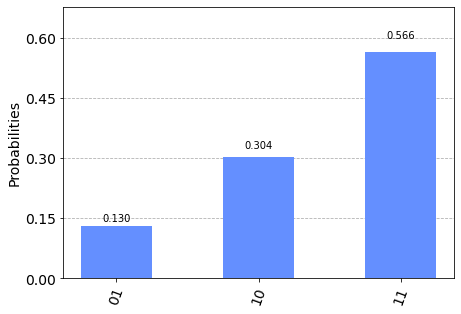

In [3]:
# Affichage de l'histogramme correspondant
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)

<h3>Référence à la partie III)B)1): Implémentation et application de l’algorithme QHED sur une image simplifiée:
</h3> 

In [4]:
# Dé-commenter et installer car requis pour la suite:
# pip install ipywidgets 

In [5]:
# Importer les bibliothèques standard de Qiskit (si pas déjà importé)
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Autres imports nécessaires
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

<h4><u> a) Initialisation: Implémentation de l’image simplifiée</u></h4> 

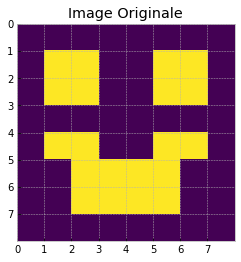

In [6]:
#Initialisation

# Mise en place d'une image binaire 8x8 représentée comme un tableau numpy
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 0, 0, 1, 1, 0],
                  [0, 1, 1, 0, 0, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 0, 0, 1, 1, 0],
                  [0, 0, 1, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

# Fonction pour tracer l'image en utilisant matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Image Originale')

<h4><u> b) Transformation de notre image classique en une image quantique via la méthode QPIE:</u></h4> 

In [7]:
# Mise en place d'une fonction de convertion des valeurs brutes des pixels d'une image en amplitudes de probabilité
def amplitude_encode(img_data):
    
    # Calculer la valeur RMS
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Créer une image normalisée
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Retourner l'image normalisée comme un tableau numpy
    return np.array(image_norm)

# Obtenez les valeurs des pixels ancodés en amplitude
# Horizontal : Image originale
image_norm_h = amplitude_encode(image)

# Vertical : Transposition de l'image originale
image_norm_v = amplitude_encode(image.T)




<h4><u> c) Mise en place de l'algorithme QHED </u></h4>

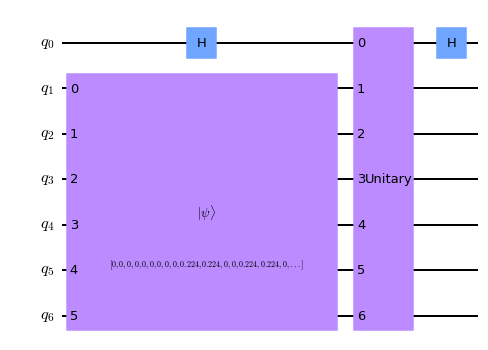

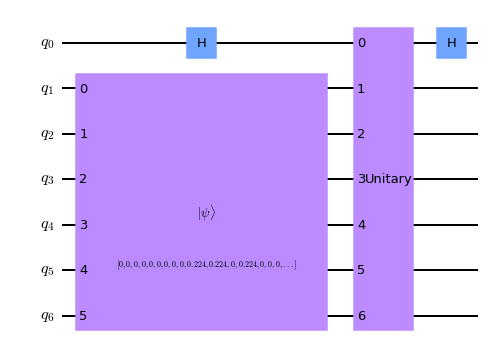

In [8]:
# Initialiser une variable globale: total_qb pour le nombre de qubits
data_qb = 6
# anc_qb repréente le qubit auxiliaire:
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialiser l'opérateur de  permutation d'amplitude unitaire
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

# Créer le circuit pour le balayage horizontal
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Créer le circuit pour le balayage vertical
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combiner les deux circuits en une seule liste
circ_list = [qc_h, qc_v]

<h4><u> d) Simulation</u></h4> 

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

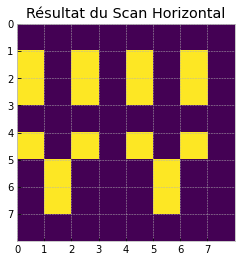

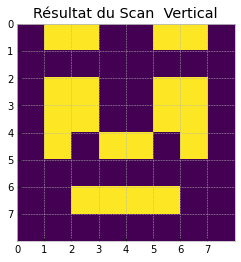

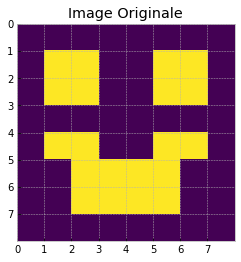

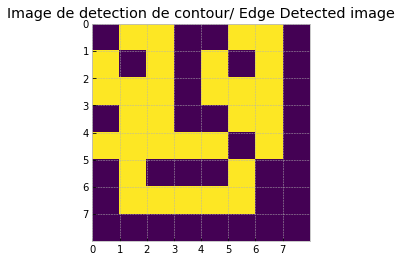

In [9]:
# Simulation des circuits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[:30], max_size=30))
print()
print('Vertical scan statevector:')
display(array_to_latex(sv_v[:30], max_size=30))

# Post-traitement classique pour le traçage de la sortie

# Définir une fonction lambda pour le "seuillage" en valeurs binaires
threshold = lambda amp: (amp > 1e-5 or amp < -1e-15)

# Sélectionner les états impairs du vecteur d'état brut et remodeler le vecteur colonne de taille 64 en une matrice 8x8.
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Tracer les balayages horizontaux et verticaux
plot_image(edge_scan_h, 'Résultat du Scan Horizontal')
plot_image(edge_scan_v, 'Résultat du Scan  Vertical')

# Combiner la composante horizontale et verticale du résultat
edge_scan_sim = edge_scan_h | edge_scan_v

# Traçage des images originales et des images détectées par les bords.
plot_image(image, 'Image Originale')
plot_image(edge_scan_sim, 'Image de detection de contour/ Edge Detected image')

<h3>Référence à la partie III)B)3): Utilisation de l’algorithme QHED implémenté sur une image réelle</h3> 

In [11]:
# Dé-commenter et installer car requis pour la suite:
# pip install scikit-image

In [12]:
# Mise en place d'une fonction permettant d'afficher la progression du gramme qui suit
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

Raw Image datatype: float32
Raw Image info: (256, 256, 4)
Raw Image datatype: float32
Image shape (numpy array): (256, 256)


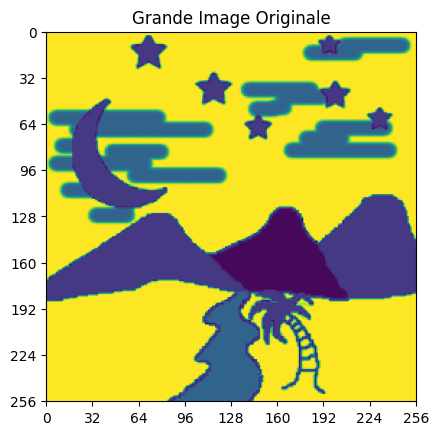

Detection de contour de l'image:
Progress: |██████████████████████████████████████████████████| 100.0% Complete


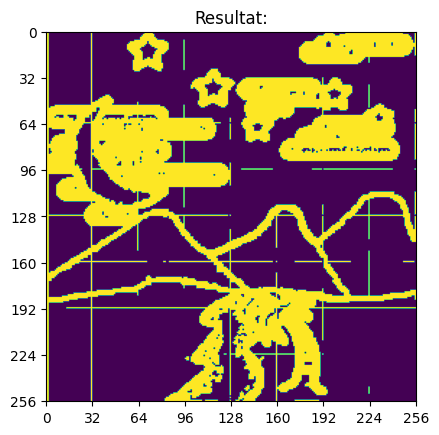

(256, 256)


In [19]:
# Import et initialisations
from skimage.transform import resize
from PIL import Image
style.use('default')
image_size = 256       # largeur et hauteur de l'image originale
image_crop_size = 32   # largeur et hauteur de chaque partie de l'image découpé pour y appliquer QHED successivement


# Etape 1: Chargelent de l'image
im = plt.imread('images/edge_detection_input.jpg')
res = resize(im, (256, 256))
image_raw = np.array(res)
print('Raw Image datatype:', image_raw.dtype)
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Etape 2: Convertir la composante RBG de l'image en image N&B, sous forme de tableau numpy (uint8)
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
image = np.array(image)
print('Image shape (numpy array):', image.shape)

# Affifage de l'image originale
plt.title('Grande Image Originale')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

print("Detection de contour de l'image:")
#affichage d'une barre de progression:
printProgressBar(0, 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
# Etape 3: Décomposer l’image en 64 images de tailles 32x32 px.
for l in range(8):
    #Décomposition de l'image en 8 image-bandes verticales 32x256px
    for k in range(8):
        #Pour chaque image bande verticale: récupération de la k^ième image 32x32px
        image = []
        for i in range(l*image_crop_size, (l+1)*image_crop_size):
            image.append([])
            for j in range(k*image_crop_size, (k+1)*image_crop_size):
                image[i-l*image_crop_size].append(image_raw[i][j][0]/31)
        image = np.array(image)
        
        # Etape 4.1:
        #Application de l'algorithme QHED implémenté précedemment sur l'image coupée/cropée: reprise du code précédent à partir de l'étape b)
        
        # Etape b):
        # Obtenez les valeurs des pixels ancodés en amplitude
        # Horizontal : Image originale
        image_norm_h = amplitude_encode(image)
        # Vertical : Transposition de l'image originale
        image_norm_v = amplitude_encode(image.T)

        # Etape c):
        # Initialiser une variable globale: total_qb pour le nombre de qubits
        data_qb = 10
        # anc_qb repréente le qubit auxiliaire:
        anc_qb = 1
        total_qb = data_qb + anc_qb
        # Initialiser l'opérateur de permutation d'amplitude
        D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
        # Créer le circuit pour le balayage horizontal
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)
        # Créer le circuit pour le balayage vertical
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)
        # Combiner les deux circuits en une seule liste
        circ_list = [qc_h, qc_v]
    
        # Etape d):
        # Simulation des circuits
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)
        # Post-traitement classique pour le traçage de la sortie
        # Définir une fonction lambda pour le "seuillage" en valeurs binaires
        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
        # Sélectionner les états impairs du vecteur d'état brut et remodeler le vecteur colonne de taille 64 en une matrice 32x32.
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T

        # Combiner la composante horizontale et verticale du résultat
        edge_scan_sim = edge_scan_h | edge_scan_v

        # Etape 4.2:
        # Reconstruction d'une image 256x256px à partir de la détection d'image réalisée sur les 64 images 32x32px représentant l'image originale:
        # concaténation des k = 0,...,7 images 32x32px "edge sccaned" en une image-bande 256x32px. 
        if k == 0:
            line_image = edge_scan_sim
        else:
            line_image = np.concatenate((line_image,edge_scan_sim),axis=1)
         #affichage d'une barre de progression:
        printProgressBar((l+1)*(k+1), 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    # concaténation des l = 0,...,7 image-bandes horizontales "edge scanned" 256x32px en une image 256x256px "edge sccaned". 
    if l == 0:
        final_image = line_image
    else:
        final_image = np.concatenate((final_image,line_image),axis=0)

# Etape 5:
plt.title('Resultat:')
plt.xticks(range(0, final_image.shape[0]+1, 32))
plt.yticks(range(0, final_image.shape[1]+1, 32))
plt.imshow(final_image, extent=[0, final_image.shape[0], final_image.shape[1], 0], cmap='viridis')
plt.show()
print(final_image.shape)

Raw Image info: (256, 256, 4)
Raw Image datatype: float32
Image shape (numpy array): (256, 256)


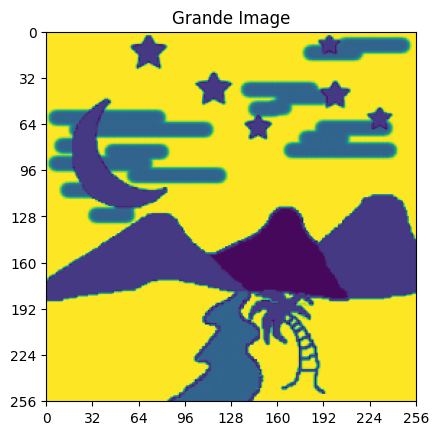

Progress: |██████████████████████████████████████████████████| 100.0% Complete


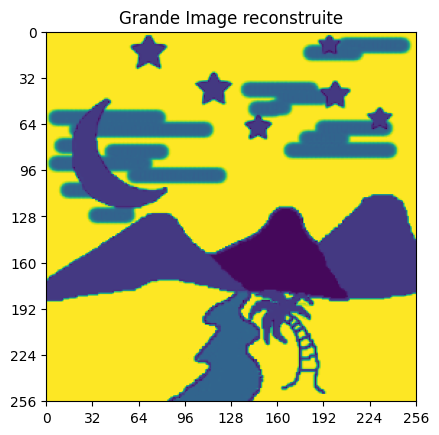

(256, 256)


In [17]:
#TEST DE DECONSTRUCTION-RECONSTRUCTION D'IMAGE
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing

# Load the image from filesystem
# image_raw = np.array(Image.open('images/edge_detection_input.jpg'))
im = plt.imread('images/edge_detection_input.jpg')
res = resize(im, (256, 256))
image_raw = np.array(res)
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)

# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)

# Display the image
plt.title('Grande Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

#affichage d'une barre de progression:
printProgressBar(0, 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
for l in range(8):
    line_image = np.arange(1024).reshape(32,32)    
    for k in range(8):
        image = []
        for i in range(l*image_crop_size, (l+1)*image_crop_size):
            image.append([])
            for j in range(k*image_crop_size, (k+1)*image_crop_size):
                image[i-l*image_crop_size].append(image_raw[i][j][0])
        image = np.array(image)
        if k == 0:
            line_image = image
        else:    
            line_image = np.concatenate((line_image,image),axis=1)
        #affichage d'une barre de progression:
        printProgressBar((l+1)*(k+1), 64, prefix = 'Progress:', suffix = 'Complete', length = 50)
    if l == 0:
        final_image = line_image
    else:
        final_image = np.concatenate((final_image,line_image),axis=0)

# Display the image
plt.title('Grande Image reconstruite')
plt.xticks(range(0, final_image.shape[0]+1, 32))
plt.yticks(range(0, final_image.shape[1]+1, 32))
plt.imshow(final_image, extent=[0, final_image.shape[0], final_image.shape[1], 0], cmap='viridis')
plt.show()
print(final_image.shape)